### Eric Maxwell
### Data Science Final Project 
<hr style="height:4px">
### Part 1: Use www.city-data.com website to gather information about major cities in each state.
+ #### Create a list of states
+ #### Create CSV file with links to major cities: city_links.csv
+ #### For each city in city_links.csv get city, state, population, education, unemployment and obesity rates and create a new CSV file: city_data1.csv. which contains this information

<hr style="height:3px">

##### Import files

In [2]:
import pandas as pd
from lxml import html
import requests
import csv

<hr style="height:3px">
### Create city_links.csv
##### Open www.city-data.com website

In [2]:
page = requests.get("http://www.city-data.com/")
tree = html.fromstring(page.content)

##### Get a list of every state and store them in the variable states

In [3]:
states = tree.xpath('//div[@class="tab-pane active"]/ul[@class="tab-list tab-list-short"]/li/a/@href')

##### Create a csv file which contains the links to the major cities for each state in the states list

In [7]:
#Open city_links.csv file for writing.
file = open('city_links.csv','w')
#Iterate through every state in the states list and add the city links to the csv file.
for state in states:
    a, b, c = state.partition("/city/")
    page1 = requests.get(state)
    tree = html.fromstring(page1.content)
    state_cities = tree.xpath('//table[@class="tabBlue tblsort tblsticky"]/tbody/tr/td/b/a/text()')
    for city in state_cities:
        city = city.split(",")[0]
        city = city.replace(" ", "-")
        city = city.replace("'","-")
        file.write(a+b+city+"-"+c+'\n')

file.close()

##### Create a data frame which contains the links to the cities

In [3]:
df = pd.read_csv("city_links.csv")
cl = df['links']

### There is now a data frame, named cl, which contains links to all the major cities. 

<hr style="height:3px">
### Gather the following data from each city link in cl to create a csv file, city_data1.csv.
+ City
+ State
+ Population
+ High school education rate
+ Bachelor's diploma rate
+ Graduate degree rate
+ Unemployment rate
+ Median Household Income
+ Obesity Rate

In [50]:
#Open file
f = open('city_data1.csv','w')

#For every city in the city list
for c in cl:
    #Open web page
    page3 = requests.get(c)
    tree3 = html.fromstring(page3.content)
    #Get the necessary information for the data frame
    city, state = tree3.xpath('//h1[@class="city"]/span/text()')[0].split(", ")
    population = (tree3.xpath('//section[@class="city-population"]/text()')[0].split('.')[0].split('(')[0].replace(",",""))
    ed_un = tree3.xpath('//section[@class="education-info"]/ul/li/text()')
    high_school = (ed_un[0].replace('%',""))
    bachelors = (ed_un[1].replace('%',""))
    grad = (ed_un[2].replace('%',""))
    unempl = (ed_un[3].replace('%',""))
    median_income = (tree3.xpath('//section[@class="median-income"]/text()')[0].replace('$','').split('(')[0].replace(",",""))
    obesity_rate = tree3.xpath('//section[@class="food-environment"]/div/table/tr/td/text()')[12].replace('%',"")
    #Write the information to the file
    f.write(city+','+state+','+population+','+high_school+','+bachelors+','+grad+','+unempl+','+median_income+','+obesity_rate+'\n')

#Close the file
f.close()

### There is now a csv file named city_data1.
### This file contains all of the information needed to create the final data frame.
<hr style="height:5px">

### Part 2: Predict Obesity Rates from City_data1.csv File Obtained in Part I of Project
+ #### Import files and create dataframe from city_data1.csv
+ #### Remove the obesity rate to use as the dependent variable
+ #### Make sure all attributes are numerical
+ #### Scale the dataframe
+ #### Use LassoCV, ElasticNetCV and RidgeCV to calculate the R-squared value
+ #### RidgeCV yielded the best results, so it will be the only model used in this project
+ #### Use RidgeCV with 10 fold cross validation to predict obesity rates

<hr style="height:3px">

In [2]:
import pandas as pd
%pylab inline
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV

Populating the interactive namespace from numpy and matplotlib


#### Create data frame from city_data1.csv file.

In [3]:
X = pd.read_csv("city_data1.csv")

#### Remove obesity rate and use as the dependent variable

In [4]:
y = X.pop('obesity_rate')

#### View first few entries of the data frame
+ Since we are using a linear model, all the data must be numerical

In [5]:
X.head()

,City,State,Population,high_school,bachelor,graduate,unemployment,median_income
0,Anchorage,Alaska,301010,92.7,33.1,11.2,6.8,79045
1,Auburn,Alabama,60258,94.9,61.3,28.9,7.4,39903
2,Birmingham,Alabama,212247,87.1,25.3,8.7,10.8,32378
3,Decatur,Alabama,55532,82.7,24.9,7.8,5.7,42837
4,Dothan,Alabama,68409,87.7,24.8,9.2,7.9,44208


#### View numerical data

In [6]:
X.describe()

,Population,high_school,bachelor,graduate,unemployment,median_income
count,9.180000e+02,918.000000,918.000000,918.000000,918.000000,918.000000
mean,1.642200e+05,86.325599,32.410893,12.197168,5.975708,61103.049020
std,3.805813e+05,8.624192,14.838171,7.809524,2.684145,21836.310206
min,5.000400e+04,41.400000,5.800000,1.200000,1.700000,23984.000000
25%,6.224750e+04,82.600000,21.025000,6.825000,4.000000,45005.500000
50%,8.514900e+04,88.100000,29.400000,10.150000,5.400000,55558.500000
75%,1.385672e+05,92.300000,41.175000,15.500000,7.400000,73884.750000
max,8.491079e+06,98.700000,83.000000,54.800000,18.700000,160291.000000


#### Remove the city attribute. It is a unique identifier.

In [7]:
X_c = X.drop('City', axis=1)

#### Check that the state variable has no null values and get the value counts for each state.

In [8]:
print("Null:",X_c.State.isnull().sum())
print(X_c.State.value_counts())

Null: 0
California              213
Florida                  83
Texas                    76
Illinois                 29
Washington               29
Michigan                 28
New York                 28
Massachusetts            25
Arizona                  24
Colorado                 23
New Jersey               23
Georgia                  20
Connecticut              19
North Carolina           18
Minnesota                18
Indiana                  17
Virginia                 16
Maryland                 15
Ohio                     15
Utah                     15
Oregon                   14
Missouri                 13
Tennessee                13
Wisconsin                12
Iowa                     11
Oklahoma                 11
Nevada                   11
Alabama                  10
Pennsylvania              9
Kansas                    9
Louisiana                 8
Arkansas                  8
South Carolina            7
Idaho                     6
Kentucky                  5
Hawaii      

#### Create a bar plot to show major city distribution per state.

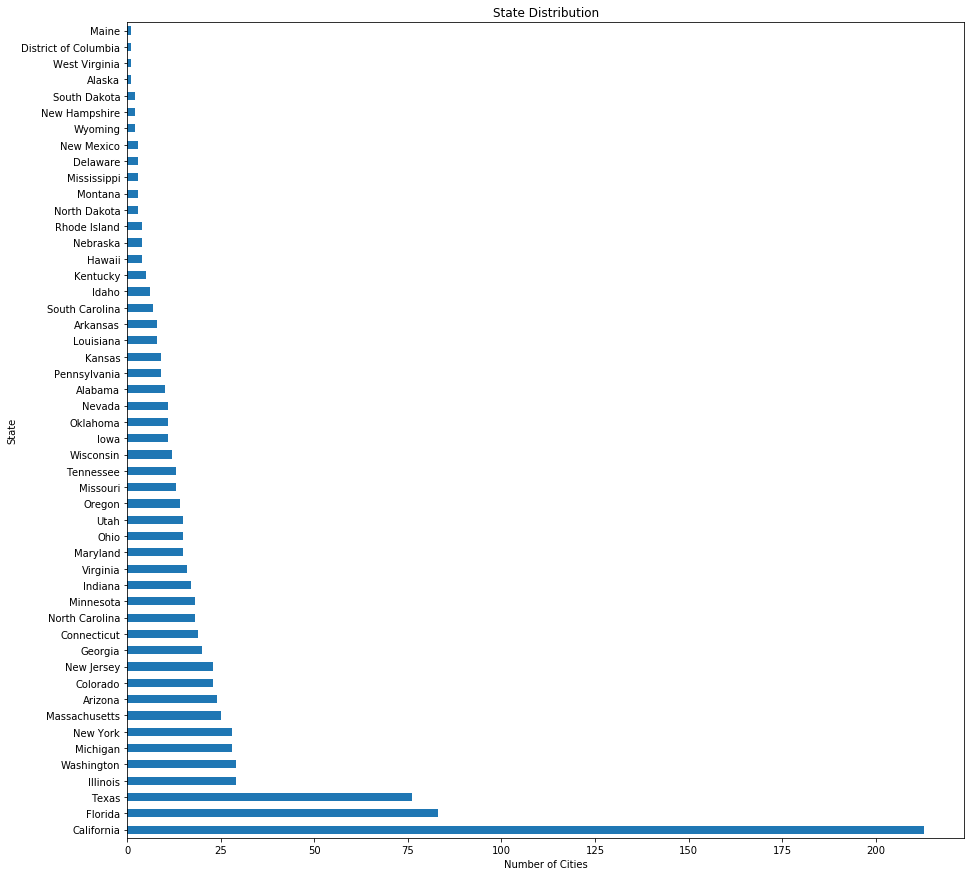

In [9]:
State_bar = X_c.State.value_counts().plot(kind='barh', title='State Distribution', figsize=(15,15))
State_bar.set(xlabel="Number of Cities", ylabel="State")

#### Create dummie variables for each state. This makes the variables numerical.

In [10]:
dummies = pd.get_dummies(X['State'], prefix='State')
# Update X to include dummies and drop the main variable
X_c = pd.concat([X_c, dummies], axis=1)
X_c.drop(['State'], axis=1, inplace=True)

#### View first few lines of data frame

In [11]:
X_c.head()

,Population,high_school,bachelor,graduate,unemployment,median_income,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,...,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,301010,92.7,33.1,11.2,6.8,79045,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60258,94.9,61.3,28.9,7.4,39903,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,212247,87.1,25.3,8.7,10.8,32378,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55532,82.7,24.9,7.8,5.7,42837,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,68409,87.7,24.8,9.2,7.9,44208,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dataframe now has all numerical attributes
<hr style="height:3px">

#### Create standard scaler

In [12]:
ss = StandardScaler()

#### Scale the dataframe and view scaled version

In [13]:
X_c_scaled = ss.fit_transform(X_c)
X_c_scaled

array([[  0.35961986,   0.73953309,   0.04646681, ...,  -0.03302291,
         -0.11508707,  -0.04672693],
       [ -0.27331523,   0.99476849,   1.9480066 , ...,  -0.03302291,
         -0.11508707,  -0.04672693],
       [  0.12626264,   0.08984296,  -0.47949101, ...,  -0.03302291,
         -0.11508707,  -0.04672693],
       ..., 
       [ -0.29922132,   0.64672021,   0.49150803, ...,  30.28200786,
         -0.11508707,  -0.04672693],
       [ -0.27376742,   0.6351186 ,  -0.62783809, ...,  -0.03302291,
         -0.11508707,  21.40093456],
       [ -0.26651403,   0.82074435,  -0.20976905, ...,  -0.03302291,
         -0.11508707,  21.40093456]])

#### Create RidgeCV linear regression model with 10 cross fold validation

In [14]:
a = np.arange(0.1, 40.0, 0.1)
rcv = RidgeCV(alphas = a, cv=10)
rcv.fit(X_c_scaled, y)

RidgeCV(alphas=array([  0.1,   0.2, ...,  39.8,  39.9]), cv=10,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

#### Display model alphpa

In [15]:
rcv.alpha_

22.900000000000002

#### Calculate R-Squared score for model

In [17]:
rcv.score(X_c_scaled,y)

0.5906707446655709

### RidgeCV model R-squared score : 0.591
+ #### This indicates that 59.1% of the variance is explained by the data.

<hr style="height:4px">

### Re-engineer the education rates for possible model improvement
+ #### Current education rates are not based on highest degree earned
+ #### For example, someone with a Bachelor's degree will also be counted as having graduated from highschool
+ #### Education rates will be changed to represent highest level of education.

<hr style="height:2px">

#### Create new data frame

In [20]:
XE = X_c

#### Change education percentages in new data frame
+ #### The percent of people who's highest education is highschool will be highschool graduates minus bachelor degree earners.
+ #### The percent of people who's highest education is a bachelor's degree will be bachelor's minus graduate degree earners.
+ #### Since graduate degrees are the highest possible degree in this study, it's value will not need to be changed.

In [21]:
XE['high_school'] = XE['high_school']-XE['bachelor']
XE['bachelor'] = XE['bachelor']- XE['graduate']

#### Check the first few lines of the data frame to see if new education rates make sense.

In [22]:
XE.head()

,Population,high_school,bachelor,graduate,unemployment,median_income,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,...,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,301010,59.6,21.9,11.2,6.8,79045,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60258,33.6,32.4,28.9,7.4,39903,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,212247,61.8,16.6,8.7,10.8,32378,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55532,57.8,17.1,7.8,5.7,42837,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,68409,62.9,15.6,9.2,7.9,44208,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Scale data for use in RidgeCV linear regression model and check result.

In [23]:
XE_scaled = ss.fit_transform(XE)
XE_scaled

array([[  0.35961986,   0.52707207,   0.21207003, ...,  -0.03302291,
         -0.11508707,  -0.04672693],
       [ -0.27331523,  -1.88333513,   1.53257587, ...,  -0.03302291,
         -0.11508707,  -0.04672693],
       [  0.12626264,   0.7310296 ,  -0.45447101, ...,  -0.03302291,
         -0.11508707,  -0.04672693],
       ..., 
       [ -0.29922132,  -0.1589669 ,   0.04857883, ...,  30.28200786,
         -0.11508707,  -0.04672693],
       [ -0.27376742,   1.37071459,  -0.59280972, ...,  -0.03302291,
         -0.11508707,  21.40093456],
       [ -0.26651403,   0.94425793,  -0.24067483, ...,  -0.03302291,
         -0.11508707,  21.40093456]])

#### Create RidgeCV model with 10 fold cross validation based on new data frame

In [24]:
rcv = RidgeCV(alphas = a, cv=10)
rcv.fit(XE_scaled, y)

RidgeCV(alphas=array([  0.1,   0.2, ...,  39.8,  39.9]), cv=10,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

#### Check to make sure alpha is within extremes

In [25]:
rcv.alpha_

5.9000000000000004

#### Calculate R-Squared score for the new model

In [26]:
rcv.score(XE_scaled,y)

0.59415852361590726

### RidgeCV model R-squared score : 0.594
+ #### This indicates that 59.4% of the variance is explained by the data.
+ #### This is slightly better than the previous model.

<hr style="height:3px">

### This study was based off of large cities, which have varied populations.
### Better results would likely be found if the study was done at the neighborhood level.
### Different areas of large cities would have very differing attributes, these have been averaged for the city.
<hr style="height:10px">